<a href="https://colab.research.google.com/github/dewaalaw/dsprojects/blob/main/traffic-flow-forecast/src/traffic_flow_forecasting_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coding Environment

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/Metro_Interstate_Traffic_Volume.csv')

train_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_train.csv')
val_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_validate.csv')
test_df = pd.read_csv('/gdrive/MyDrive/TrafficFlowData/metro_interstate_traffic_volume_test.csv')

# Data Windowing

Rather than setting predifined functions to determine which of their ordering resulted in the model best fit (as in the case of the SARIMAX statistical model), neural networks derive their own function to determine a best possible fit. This processual difference is however achieved by data-windowing, by defining a sequence of data points 

In [ ]:
class DataWindow():
  # Initialise a DataWindow object
  def __init__(self, input_width, label_width, shift, train_df=train_df, 
             val_df=val_df, test_df=test_df, label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    
    # Name of column to predict
    self.label_columns = label_columns
    if label_columns is not None:
      # Dict. of name and index of label column. Used for plotting.
      self.label_columns_indices = {name: i for i, name in 
                                    enumerate(label_columns)}
    # Dict. of name and index of each column. Used for plotting.
    # Used to seperate the features from target variable
    self.column_indices = {name: i for i, name in 
                                    enumerate(train_df.columns)}
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    # Returns a slice object that specifies how to slice a sequence.
    # In this case, it says that hte input slice starts at 0, ends when 
    # input_width is reached
    self.input_slice = slice(0, input_width)
      
    # Assign indices to the inputs. These are usefull for plotting.
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
      
    # Get the index at which the label starts. In this case, it's the total 
    # window size less the width of the label.
    self.label_start = self.total_window_size - self.label_width
    # Repeat steps applied for input for labels
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  
  # Seperate the big data window into two windows: one for inputs, 
  # the other for the lables
  def split_to_inputs_labels(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], 
          axis=-1
      )
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  # Plot sample of data windows
  def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
    inputs, labels=self.sample_batch

    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [scaled]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
               label='Inputs', marker='.', zorder=-10)
      
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue  
      
      plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                  edgecolors='k', marker='s', label='Labels', c='green', s=64)
      
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='red', 
                    s=64)
      
      if n == 0:
        plt.legend()
    
    plt.xlabel('Time (h)')
  
  # Format dataset into tensors, fed to dl model.
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # Use tensor timeseries_dataset_from_array function to create a dataset of 
    # sliding windows.
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data,
        # targets are handled by the split_to_input_labels function, 
        # thus set to none.
        targets = None,
        sequence_length = self.total_window_size,
        # Number of timesteps seperating each sequence.
        # In this case sequences are consecutive hence sequence_stride equall 1
        sequence_stride = 1,
        # Shuffle the batch sequence, not the window/sequence timesteps
        shuffle = True,
        # Sequences in a batch
        batch_size=32
    )

    ds = ds.map(self.split_to_inputs_labels)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)
    
  @property
  def val(self):
    return self.make_dataset(self.val_df)
    
  @property
  def test(self):
    return self.make_dataset(self.test_df)
    
  @property
  def sample_batch(self):
    result = getattr(self, '_sample_batch', None)
    if result is None:
      result = next(iter(self.train))
      self._sample_batch = result
    return result

# Baseline Models

## Single-step Baseline Model

In [ ]:
# Create single-step baseline Model
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [ ]:
# The Baseline class is a subclass of Tensorflow
class Baseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index
        
  def call(self, inputs):
    # Return all columns if no target is specified.
    # Usefull for multi-output models where all columns are predicted.
    if self.label_index is None:
      return inputs
    # Specify a list of columns to be predicted- 
    # as in the case of a multi-output model. 
    elif isinstance(self.label_index, list):
      tensors = []
      for index in self.label_index:
        result = inputs[:, :, index]
        result = result[:, :, tf.newaxis]
        tensors.append(result)
      return tf.concat(tensors, axis=-1)
        
    result = inputs[:, :, self.label_index]
    return result[:,:,tf.newaxis]

In [ ]:
# A dictionary for the name and index of each column in the training set.
column_indices = {name: i for i, name in enumerate(train_df.columns)}
# Pass index of the target column in the Baseline class.
baseline_last = Baseline(label_index=column_indices['traffic_volume'])
# Compile model to generate predictions
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [ ]:
# Dictionary to hold the MAE of a model on a validation set.
val_performance = {}
# Dictionary to hold the MAE of a model on the test set.
performance =  {}
# Store the MAE of the baseline on the validation set.
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
# Store the MAE of the baseline on the test set.
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, 
                                                        verbose=0)

110/110 [==============================] - 1s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


#### Plots

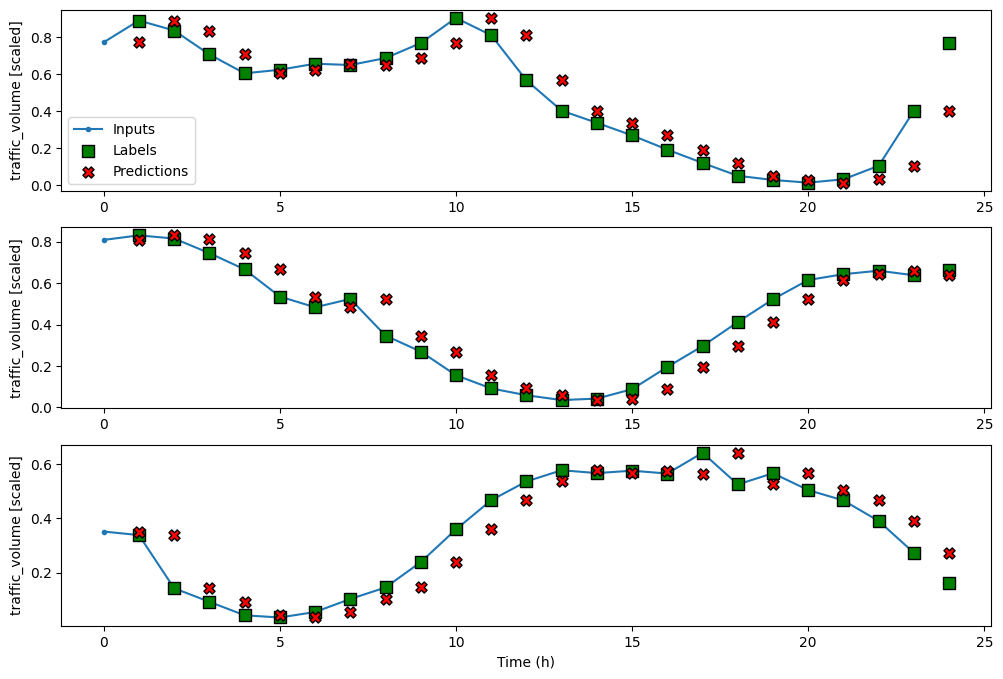

In [ ]:
wide_window.plot(baseline_last)

## Multi-Step Baseline Model

Next we predict more than one timestep into the future. Forecast the traffic volume for the following 24 hours of data given an input of 24 hours. Generate a fitting data window. Since we are predicting 24 timesteps into the future with an input of 24 *hours*, the input width, label width, and shift will be 24.

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, 
                          label_columns=['traffic_volume'])

### Predict the last known value for the next 24 hours

In [ ]:
class MultiStepLastBaseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      # Return the last known value of the target column over the next 
      # 24 timesteps.
      return tf.tile(inputs[:, -1:, :], [1, 24, 1])
    # Return the last known value of all columns over the next 24 hours 
    # if no target is specified.
    return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [ ]:
ms_baseline_last = MultiStepLastBaseline(
    label_index=column_indices['traffic_volume']
    )

ms_baseline_last.compile(loss=MeanSquaredError(), 
                         metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(
    multi_window.val
    )
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(
    multi_window.test, verbose=0
    )

109/109 [==============================] - 1s 6ms/step - loss: 0.1874 - mean_absolute_error: 0.3520


#### Plots

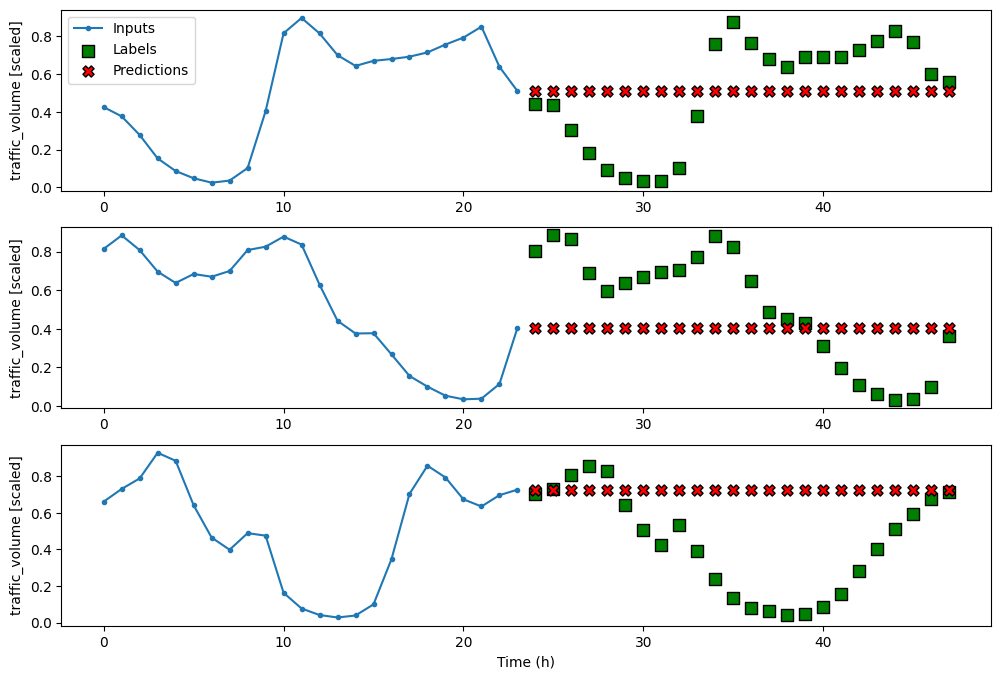

In [ ]:
multi_window.plot(ms_baseline_last)

#### Performance: Means Absolute Error (MAE)

In [ ]:
print(ms_performance['Baseline - Last'][1])

0.34706419706344604


### Repeat the Input Sequence

In [ ]:
class RepeatBaseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    # Return the input sequence for the given time column
    return inputs[:, :, self.label_index:]

In [ ]:
# Initialise the baseline model
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)

ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.2125 - mean_absolute_error: 0.3533


#### Plots

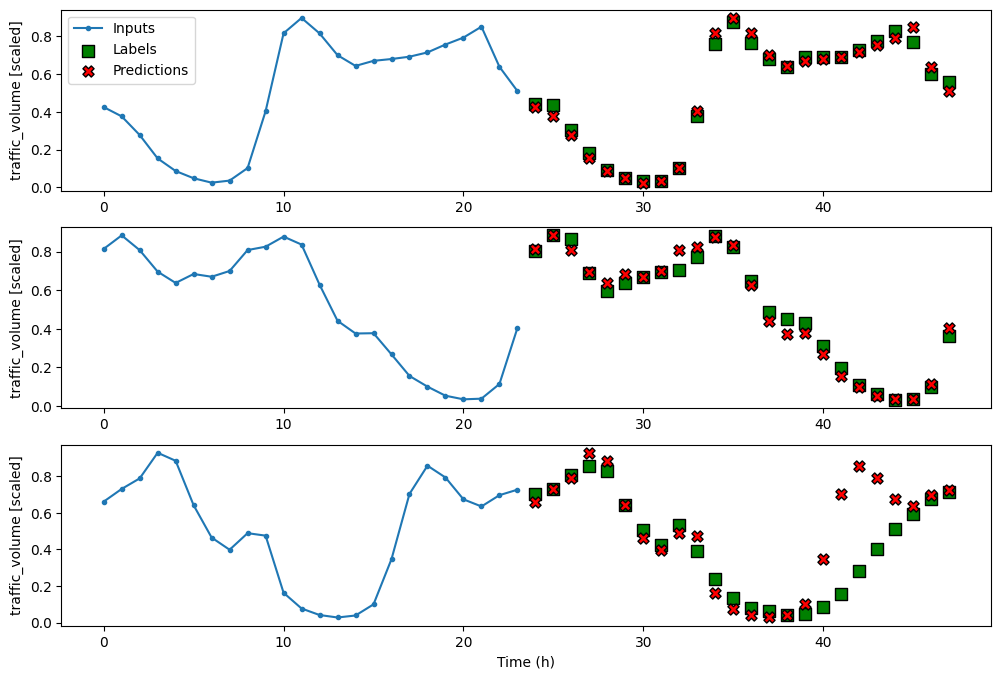

In [ ]:
multi_window.plot(ms_baseline_repeat)

#### Performance: MAE



In [ ]:
print(ms_performance['Baseline - Repeat'][1])

0.34390464425086975


## Multi-output Baseline Model

This models aims to predict more than one output; that is, predict the traffic volume and temperature by way of a single step model. 

In [ ]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, 
                                   label_columns=['temp', 'traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, 
                            label_columns=['temp', 'traffic_volume'])

In [ ]:
# Pass the indexes of the temperature and traffic volumes to print the last 
# known value as a prediction.
# ci_traffic_volume = column_indices['traffic_volume']
# ci_temp = column_indices['temp']
print(column_indices['traffic_volume']) # Prints out 2
print(column_indices['temp']) # Prints out 0

3
1


In [ ]:
# Initialise Baseline with two target variables
# mo_baseline_last = Baseline(label_index=[ci_traffic_volume, ci_temp])
mo_baseline_last = Baseline(label_index=[1, 3])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

# Compile model and evaluate performance
mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, 
                                                              verbose=0)

109/109 [==============================] - 1s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


#### Plot

##### Traffic Volume

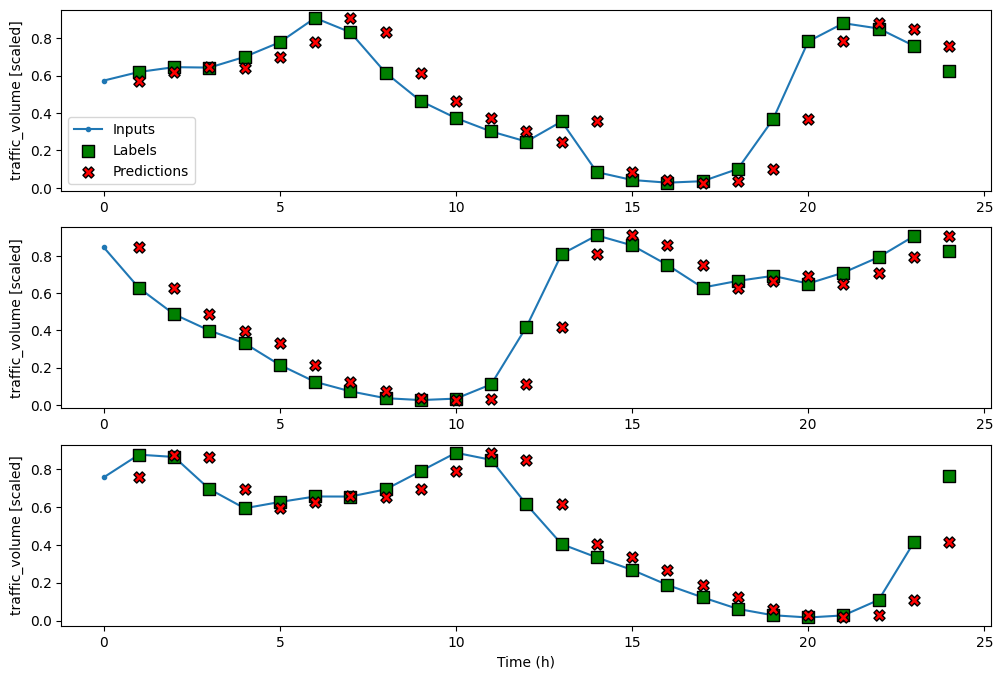

In [ ]:
# Visualise predictions against actual values
mo_wide_window.plot(mo_baseline_last)

##### Temperature

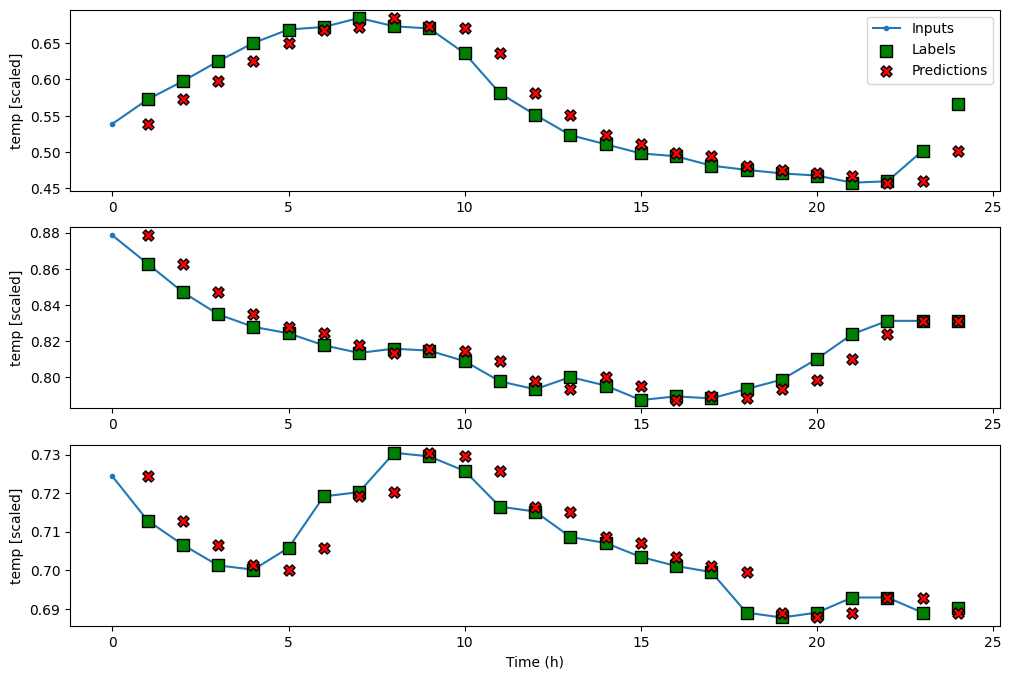

In [ ]:
# Visualise predictions for temperature
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [ ]:
print(mo_performance['Baseline - Last'])

[0.006438457407057285, 0.04710666462779045]


# Linear Model

A linear model is deep learning model without a hidden layer. Strictly speaking, a linear model in this respect is in fact not a deep learning model since it's devoid of a hidden layer. Hence, the model equation resembles the function of a multivariate linear model.  

## Single-step Linear model

In [ ]:
# DEF: Configure deep learning model and fit data.
# patience: number of epochs after which model stops training-
# granted the validation loss does not improve.
# max_epochs: maximum number of epochs to train the model. Method stops when 3- 
# consecutive epochs do not decrease the validation loss.
def compile_and_fit(model, window, patience=3, max_epochs=50):
  early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=patience, 
                                 mode='min')
  
  model.compile(loss=MeanSquaredError(), # Use MSE as loss function.
                # Adam's an optimiser proivding a method that descends the 
                # gradient applied to the weights of the layers.
                # Use MAE as error metric
                optimizer=Adam(),
                metrics=[MeanAbsoluteError()]) 
  
  history = model.fit(window.train, # Fit model on training set
                      epochs=max_epochs, 
                      validation_data=window.val, # Use validation set to calc validation loss
                      callbacks=[early_stopping]) # Pass early_stopping as a calllback
  
  return history

In [ ]:
# The Sequential model from Kerras allows for the stacking of different layers
# A linear model requires only 1 layer — i.e. a Dense layer, the most layer in deep learning
linear = Sequential([Dense(units=1)])

# Train model and store performance for later comparison
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 3s 6ms/step - loss: 904676.9375 - mean_absolute_error: 711.4366 - val_loss: 126353.3438 - val_mean_absolute_error: 354.5436
Epoch 2/50
384/384 [==============================] - 4s 9ms/step - loss: 4542.6934 - mean_absolute_error: 41.2435 - val_loss: 22.1648 - val_mean_absolute_error: 4.6799
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.6724 - mean_absolute_error: 0.5691 - val_loss: 0.1791 - val_mean_absolute_error: 0.3454
Epoch 4/50
384/384 [==============================] - 3s 7ms/step - loss: 0.1785 - mean_absolute_error: 0.3477 - val_loss: 0.1790 - val_mean_absolute_error: 0.3453
Epoch 5/50
384/384 [==============================] - 4s 11ms/step - loss: 0.1783 - mean_absolute_error: 0.3476 - val_loss: 0.1788 - val_mean_absolute_error: 0.3451
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.1782 - mean_absolute_error: 0.3475 - val_loss: 0.1788 - val_mean_absolute_error: 0.3

#### Plot

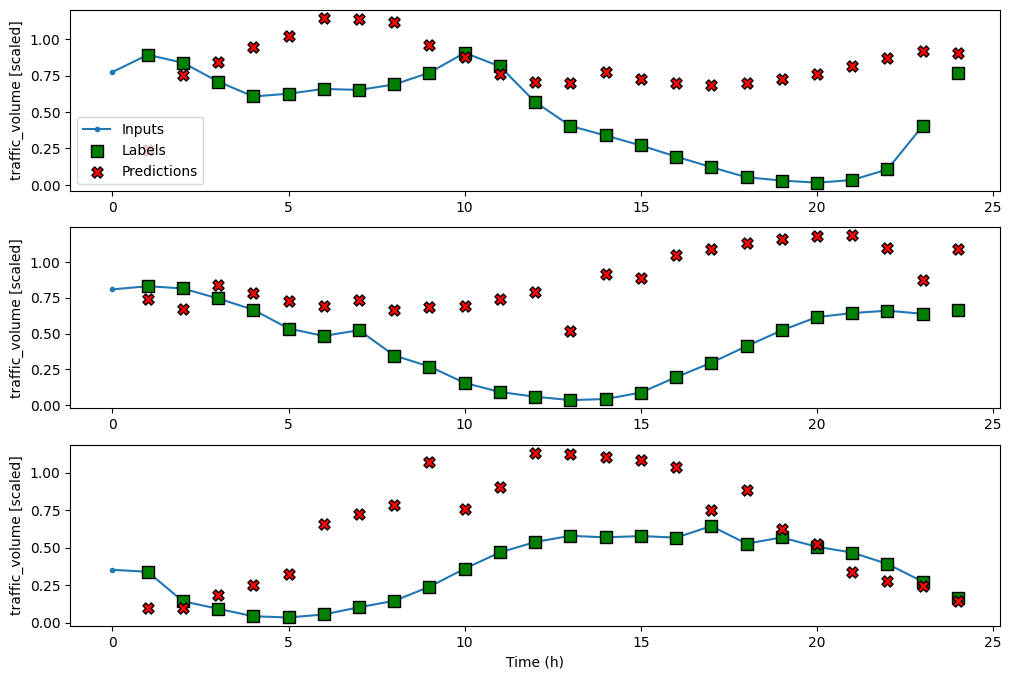

In [ ]:
wide_window.plot(linear)

## Multi-Step Linear Model

In a multi-step prediction we foreground the next 24 hours of data using and input window of 24 hours of data — focusing only on the traffic volume.

In [ ]:
# Initialise the weights to 0, to make training faster
ms_linear = Sequential([Dense(1, kernel_initializer=tf.initializers.zeros)])

# Train model and store performance for later comparison
history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 3s 7ms/step - loss: 0.6973 - mean_absolute_error: 0.4255 - val_loss: 0.2080 - val_mean_absolute_error: 0.3823
Epoch 2/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0707 - mean_absolute_error: 0.2229 - val_loss: 0.3342 - val_mean_absolute_error: 0.5323
Epoch 3/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0463 - mean_absolute_error: 0.1782 - val_loss: 0.2977 - val_mean_absolute_error: 0.5109
Epoch 4/50
383/383 [==============================] - 4s 9ms/step - loss: 0.0345 - mean_absolute_error: 0.1485 - val_loss: 0.0445 - val_mean_absolute_error: 0.1674
Epoch 5/50
383/383 [==============================] - 3s 6ms/step - loss: 0.1358 - mean_absolute_error: 0.2431 - val_loss: 0.0576 - val_mean_absolute_error: 0.2020
Epoch 6/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0570 - mean_absolute_error: 0.1568 - val_loss: 0.0206 - val_mean_absolute_error: 0.1051
Epoch 7/50
383/3

#### Plot

All things equal, the predictions are rather accurate, given the amount of overlap of predictions on actual values. 

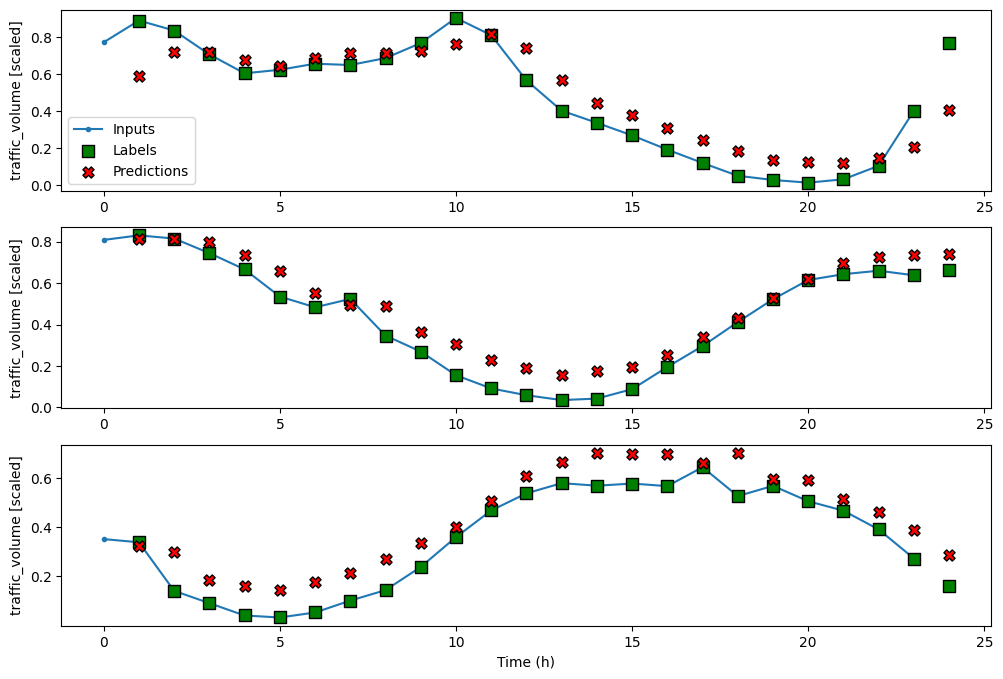

In [ ]:
wide_window.plot(ms_linear)

## Multi-Output Linear Model

The said model produces more than one predciton — in this case, traffic volume and temperature. Data input is the present timestep, combining them in a single layer, while the prediction is the next timestep.

In [ ]:
# Since the prediction is volume and temperature, the dense layer contains 2 units
mo_linear = Sequential([Dense(units=2)])

# Train model and store performance for later comparison
history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 3s 7ms/step - loss: 13884022.0000 - mean_absolute_error: 2888.2520 - val_loss: 28654516.0000 - val_mean_absolute_error: 4550.3433
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 4094257.5000 - mean_absolute_error: 1384.4000 - val_loss: 7515368.5000 - val_mean_absolute_error: 2058.2578
Epoch 3/50
384/384 [==============================] - 3s 9ms/step - loss: 957659.3750 - mean_absolute_error: 602.6151 - val_loss: 1400372.8750 - val_mean_absolute_error: 842.6704
Epoch 4/50
384/384 [==============================] - 3s 7ms/step - loss: 151272.0625 - mean_absolute_error: 228.4112 - val_loss: 159192.4688 - val_mean_absolute_error: 281.8584
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 14241.5996 - mean_absolute_error: 68.0236 - val_loss: 9916.7275 - val_mean_absolute_error: 70.5573
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 720.0009 - mean_absolute_error

#### Plot

##### Traffic Volume

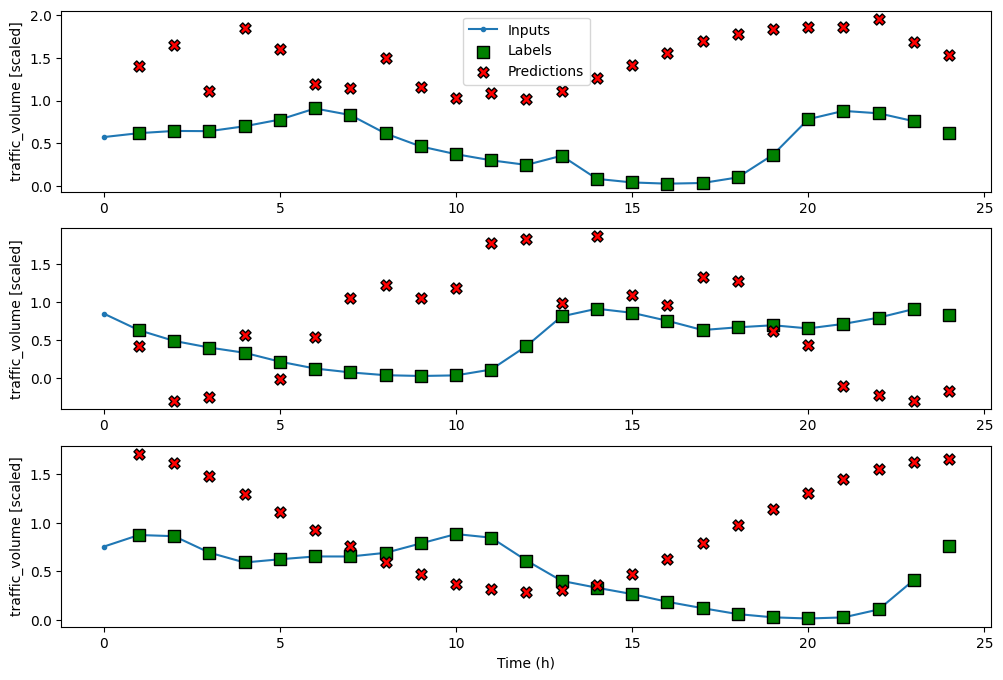

In [ ]:
mo_wide_window.plot(mo_linear)

##### Temperature

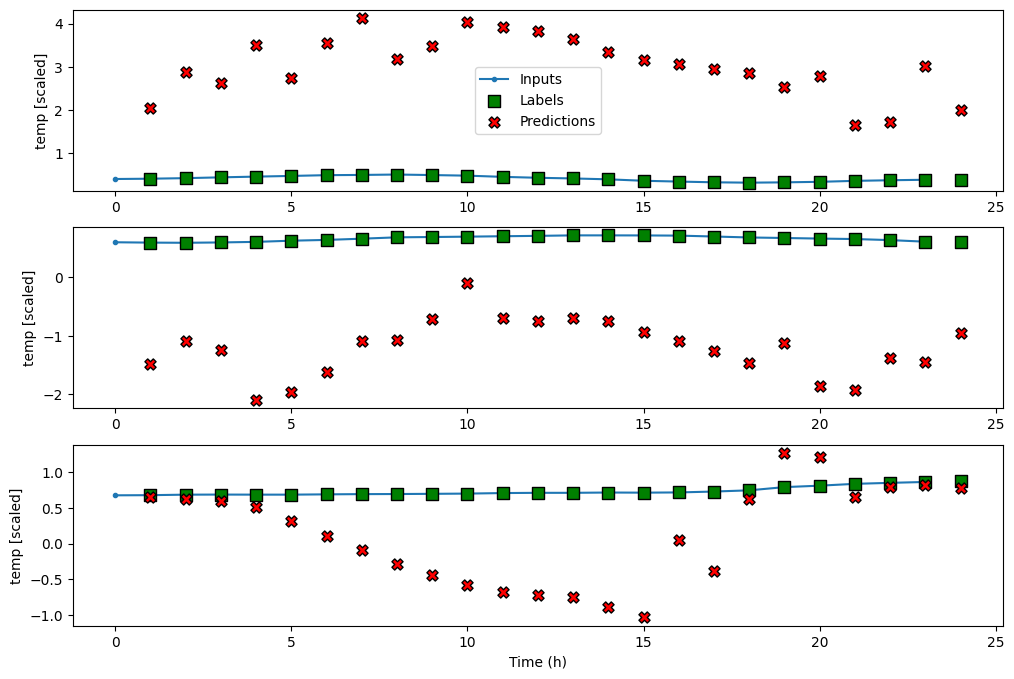

In [ ]:
mo_wide_window.plot(model=mo_linear, plot_col='temp')

# Deep Neural Network (DNN)

DNN's contains hidden layers while linear models are absent thereof, containing only an input and output layer. Contrary to linear models, DNN's sandwich hidden layers between the input and output layer. More layers imply better learning, thus allowing the model to improve generalising new data. The downside, however, the model takes longer to train.

## Single-Step DNN Model

In [ ]:
# Activation function: Relu (i.e., rectified linear unit)
# Hidden Layers: 2
# Neurons: 64
dense = Sequential([Dense(units=64, activation='relu'),
                    Dense(units=64, activation='relu'),
                    Dense(units=1)])

# Compile, train, and evaluate model performance
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 6s 11ms/step - loss: 565.8820 - mean_absolute_error: 5.9571 - val_loss: 0.1527 - val_mean_absolute_error: 0.3188
Epoch 2/50
384/384 [==============================] - 4s 10ms/step - loss: 0.1635 - mean_absolute_error: 0.3320 - val_loss: 0.3077 - val_mean_absolute_error: 0.4633
Epoch 3/50
384/384 [==============================] - 3s 8ms/step - loss: 4.5995 - mean_absolute_error: 0.9220 - val_loss: 1.6431 - val_mean_absolute_error: 1.2387
Epoch 4/50
384/384 [==============================] - 5s 13ms/step - loss: 0.5889 - mean_absolute_error: 0.5052 - val_loss: 0.1255 - val_mean_absolute_error: 0.2969
Epoch 5/50
384/384 [==============================] - 3s 8ms/step - loss: 3.1094 - mean_absolute_error: 0.9041 - val_loss: 22.6810 - val_mean_absolute_error: 4.7390
Epoch 6/50
384/384 [==============================] - 3s 8ms/step - loss: 96.1104 - mean_absolute_error: 4.5505 - val_loss: 0.5899 - val_mean_absolute_error: 0.7171
Epoch 7/5

#### Plot

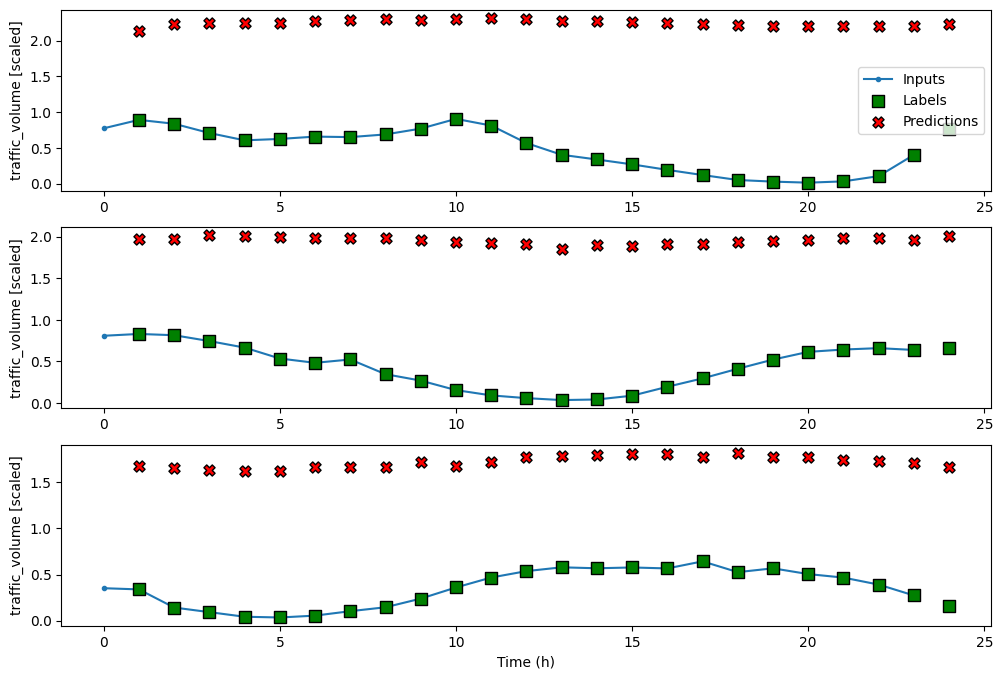

In [ ]:
wide_window.plot(dense)

### Compare Models (Linear vs DNN)

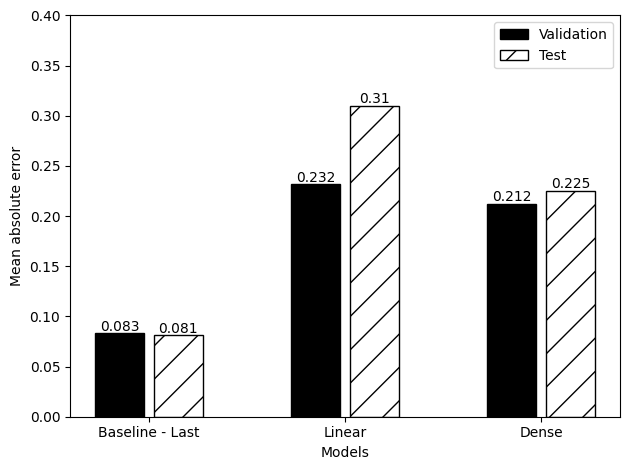

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')
  
for index, value in enumerate(mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## Multi-Step Model
Predict the next 24 hours of traffic volume on the last 24 hours of recorded data.

In [ ]:
# Activation function: Relu (i.e., rectified linear unit)
# Hidden Layers: 2
# Neurons: 64
ms_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, kernel_initializer=tf.initializers.zeros),
    ])

# Compile, train, and evaluate model performance
history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 5s 11ms/step - loss: 2.2155 - mean_absolute_error: 0.5521 - val_loss: 0.1458 - val_mean_absolute_error: 0.3029
Epoch 2/50
383/383 [==============================] - 3s 8ms/step - loss: 0.1186 - mean_absolute_error: 0.2862 - val_loss: 0.1851 - val_mean_absolute_error: 0.3459
Epoch 3/50
383/383 [==============================] - 3s 8ms/step - loss: 0.1588 - mean_absolute_error: 0.3031 - val_loss: 0.1276 - val_mean_absolute_error: 0.2836
Epoch 4/50
383/383 [==============================] - 3s 9ms/step - loss: 0.1116 - mean_absolute_error: 0.2724 - val_loss: 0.1151 - val_mean_absolute_error: 0.2711
Epoch 5/50
383/383 [==============================] - 4s 10ms/step - loss: 0.0883 - mean_absolute_error: 0.2564 - val_loss: 0.1061 - val_mean_absolute_error: 0.2627
Epoch 6/50
383/383 [==============================] - 3s 7ms/step - loss: 0.0824 - mean_absolute_error: 0.2495 - val_loss: 0.0904 - val_mean_absolute_error: 0.2503
Epoch 7/50
383

#### Plot

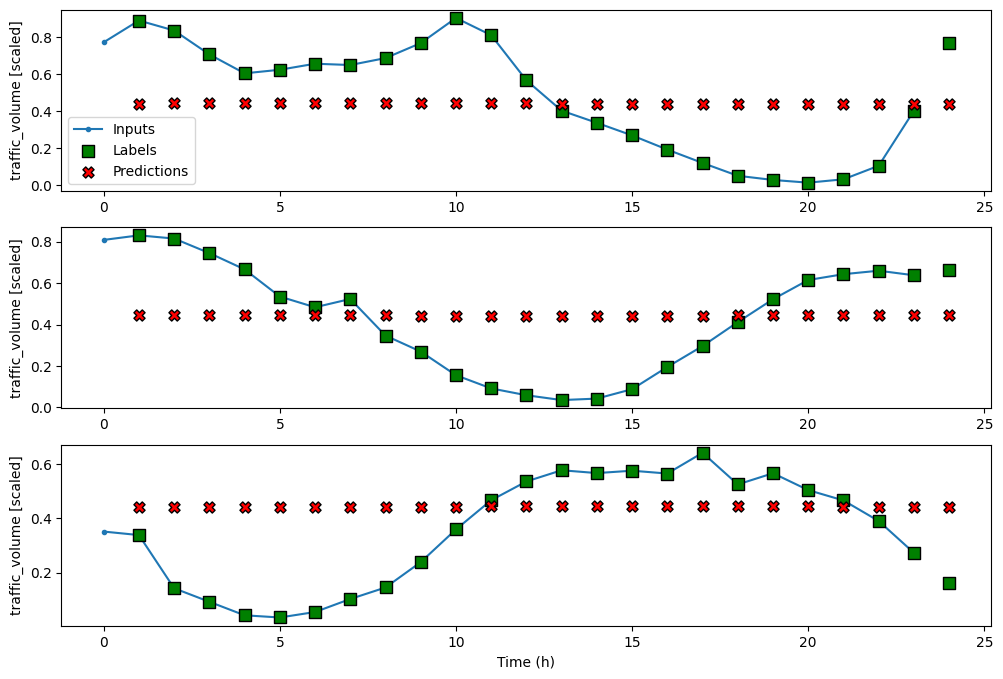

In [ ]:
wide_window.plot(ms_dense)

#### Compare Model Performance

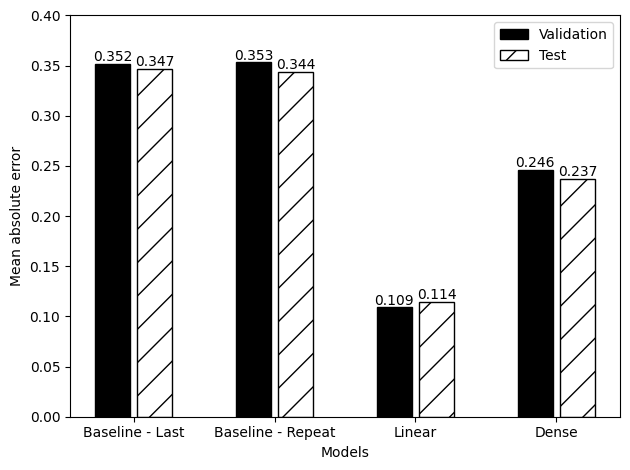

In [ ]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')
  
for index, value in enumerate(ms_mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()


## Multi-Output DNN Model

In [ ]:
mo_dense = Sequential([Dense(units=64, activation='relu'),
                       Dense(units=64, activation='relu'),
                       Dense(units=2)])
# %load_ext tensorboard
# %tensorboard --logdir logs
history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 6s 12ms/step - loss: 5271.9937 - mean_absolute_error: 16.0026 - val_loss: 0.3866 - val_mean_absolute_error: 0.4712
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 0.1548 - mean_absolute_error: 0.3240 - val_loss: 0.4322 - val_mean_absolute_error: 0.6044
Epoch 3/50
384/384 [==============================] - 3s 7ms/step - loss: 0.7017 - mean_absolute_error: 0.4710 - val_loss: 0.2193 - val_mean_absolute_error: 0.3547
Epoch 4/50
384/384 [==============================] - 4s 10ms/step - loss: 1.4147 - mean_absolute_error: 0.5491 - val_loss: 0.1594 - val_mean_absolute_error: 0.3378
Epoch 5/50
384/384 [==============================] - 3s 7ms/step - loss: 0.1929 - mean_absolute_error: 0.3327 - val_loss: 0.1365 - val_mean_absolute_error: 0.3031
Epoch 6/50
384/384 [==============================] - 3s 8ms/step - loss: 0.1235 - mean_absolute_error: 0.2833 - val_loss: 0.1880 - val_mean_absolute_error: 0.3368
Epoch 7/50

#### Plot

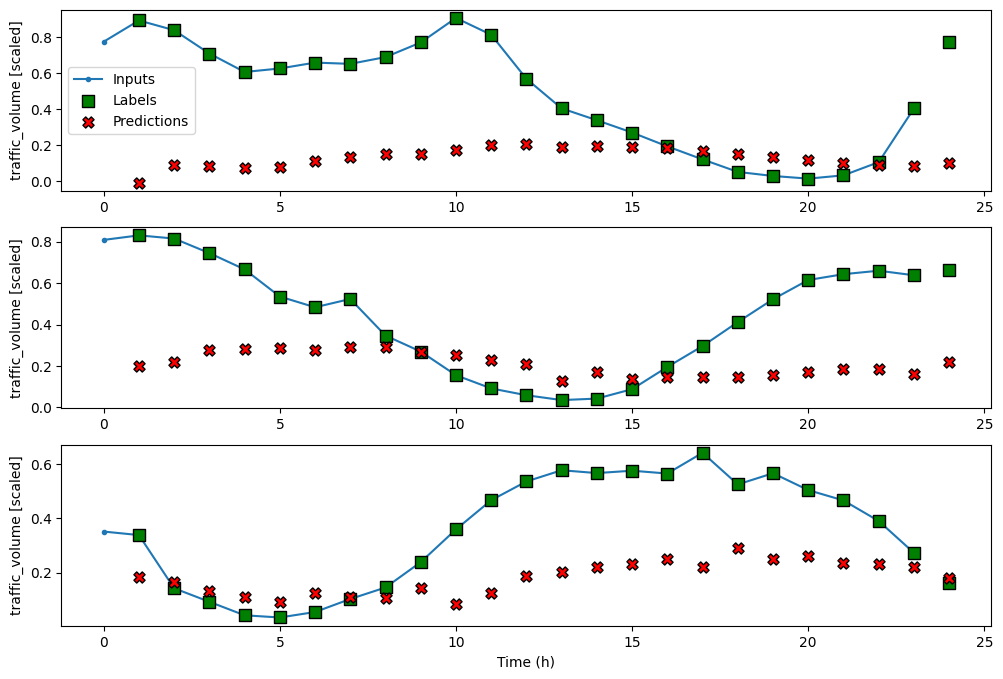

In [ ]:
wide_window.plot(mo_dense)

#### Compare Model Performance

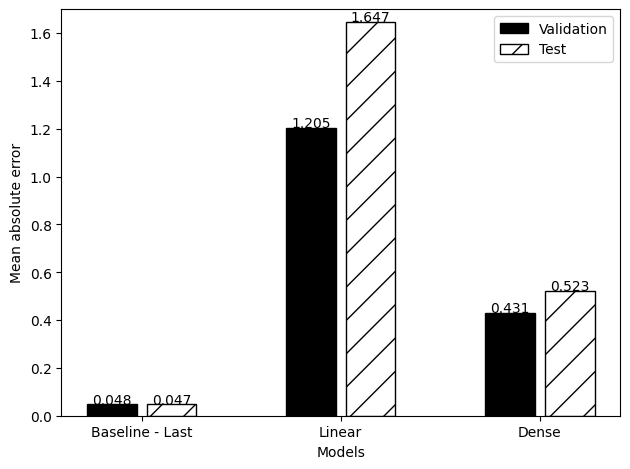

In [ ]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', 
       label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black',
       hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
  plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha = 'center')
  
for index, value in enumerate(mo_mae_test):
  plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),
           ha='center')

plt.ylim(0, 1.7)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()